In [ ]:
from google.colab import drive
drive.mount('/content/drive')

How to get amazon_reviews.csv one may wonder. It's here in public accses https://nijianmo.github.io/amazon/index.html

In [ ]:
import re
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Text_Gen_project/amazon_reviews.csv')

def preprocess(text):
	text_input = re.sub('[^a-zA-Z1-9]+', ' ', str(text))
	output = re.sub(r'\d+', '',text_input)
	return output.lower().strip()

data['reviewText'] = data.reviewText.map(preprocess)
corpus_cleaned = data['reviewText'].astype(str).values.tolist()

In [ ]:
# for siplicity, we keep only reviews with 12 words
sentences = []
sentence_length = []
num_words = 12 # LESS than an hour training time =(

for item in corpus_cleaned:
	word_list = item.split()
	sentences.append(item)
	number_of_words = len(word_list)
	sentence_length.append(number_of_words)

sentences = pd.DataFrame(sentences)
sentence_length = pd.DataFrame(sentence_length)

sentences = sentences.merge(sentence_length, left_index=True, right_index=True)

sentences['number_of_words']=sentences['0_y']
sentences['sentence']=sentences['0_x']
sentences=sentences[['sentence','number_of_words']]
sentences['number_of_words']=sentences['number_of_words'].astype(int)

sentences = sentences[sentences['number_of_words'] == num_words]
corpus_cleaned=sentences['sentence'].values.tolist()
corpus = corpus_cleaned

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# create input sequences using list of tokens
input_sequences = []

for review in corpus:
	token_list = tokenizer.texts_to_sequences([review])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

In [ ]:
import tensorflow.keras.utils as ku
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
total_words = len(tokenizer.word_index) + 1
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import tensorflow as tf

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 240, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
!pip install livelossplot
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='loss', mode='min',
    filepath='/content/drive/MyDrive/Text_Gen_project/training_checkpoints_Peter.h5',
    save_weights_only=True,
    verbose=1,
    save_best_only=True)

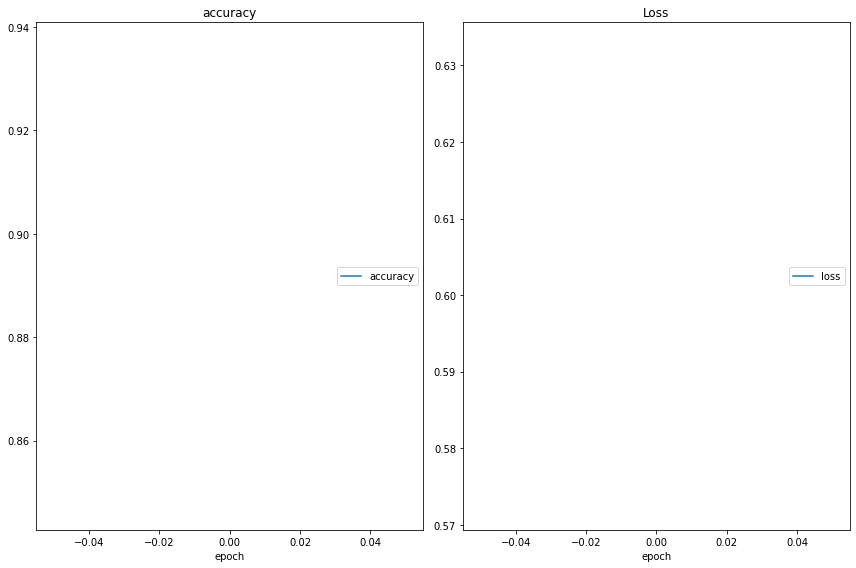

accuracy
	accuracy         	 (min:    0.892, max:    0.892, cur:    0.892)
Loss
	loss             	 (min:    0.602, max:    0.602, cur:    0.602)
312/312 [==============================] - 39s 114ms/step - loss: 0.6025 - accuracy: 0.8918


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy')>0.89): # goal was above 94%, but you need less that an hour without GPU, right?
			print("\nReached 89% accuracy so cancelling training!")
			self.model.stop_training = True

callbacks = myCallback()

history = model.fit(predictors, label, epochs=300, verbose=1, callbacks=[callbacks, checkpoint_callback, PlotLossesCallback()])

In [ ]:
model.save('/content/drive/MyDrive/Text_Gen_project/Peter_model.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Text_Gen_project/Peter_model.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/Text_Gen_project/training_checkpoints_Peter.h5')

In [ ]:
history.history['accuracy'][-1]

0.8918131589889526

In [ ]:
def TextGenerator(seed_text, lenght):

	for _ in range(lenght):
		token_list = tokenizer.texts_to_sequences([seed_text])[0]
		token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
		predicted = model.predict(token_list, verbose=0)
		output_word = ""
		for word, index in tokenizer.word_index.items():
			if index == np.argmax(predicted):
				output_word = word
				break
		seed_text += " " + output_word

	seed_text = (seed_text + ".").capitalize()
	print(seed_text)

In [ ]:
TextGenerator('I love my baby', 20)

I love my baby the have this song so so moving tight beats and romantic public radio harmony down perfect copy to it again.
